## Setup - Do once (Only in Colab)

In [1]:
try:
    import google.colab
    IN_COLAB = True
    
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir('/content/drive/My Drive/Colab Notebooks/RoboAdvisor')
    print('Working directory changed to ' + os.getcwd())  

except:
    IN_COLAB = False




In [2]:
if (IN_COLAB):
    %%capture
    !pip install zipline
    !pip install pyfolio
    !pip install cvxopt
    !pip install yahoofinancials

In [3]:
if (IN_COLAB):
    # Some files need to be modified
    !ls /root
    #!cp setup/extension.py ~/.zipline/extension.py
    !cp setup/benchmarks.py /usr/local/lib/python3.6/dist-packages/zipline/data/benchmarks.py
    !cp setup/loader.py /usr/local/lib/python3.6/dist-packages/zipline/data/loader.py


## Input and Function definitions

In [4]:
#@title Input Variables
_visualise = True #@param ["True", "False"] {type:"raw"}
_bundle_start_date = '2015-01-05' #'2015-01-05' #@param {type:"date"}
_bundle_end_date = '2020-03-12' #@param {type:"date"}
# _end_date = '2019-12-27' #@param {type:"date"}
_capital = 1000000 #@param {type:"slider", min:1000, max:1000000, step:1000}
_benchmark = 'SPY' #@param ["SPY"] {allow-input: true}
_history = 500 #@param {type:"slider", min:100, max:500, step:1}
_calendar = 'NYSE' #@param ["NYSE"] {allow-input: true}

# set algo start date equal to bundle start date
# _start_date = _bundle_start_date
# _end_date = _bundle_end_date

_start_date = '2018-07-21'
_end_date = '2020-03-12'

args = {
    'mode': '1',
    'visualise': _visualise, 
    'start_date': _start_date,
    'end_date': _end_date,
    'bundle_start_date': _bundle_start_date,
    'bundle_end_date': _bundle_end_date,
    'bundle': 'robo-advisor_US',
    'timezone': 'US/Mountain',
    'calendar': _calendar,
    'capital': _capital,
    'benchmark': _benchmark,
    'history': _history
}


### Register and ingest bundle

In [5]:
import pandas as pd
from zipline.data.bundles import register, ingest, unregister, bundles
from zipline.data.bundles.csvdir import csvdir_equities

import os
from zipline.utils.run_algo import load_extensions

start_session = pd.Timestamp(args['bundle_start_date'], tz='utc')
end_session = pd.Timestamp(args['bundle_end_date'], tz='utc')
bundle_name = args['bundle']

load_extensions(default=True, extensions=[], strict=True, environ=os.environ)

# unregister bundle if already exists
if bundle_name in list(bundles):
    unregister(bundle_name)

# register and ingest the bundle
register(
    bundle_name,  # name we select for the bundle
    csvdir_equities(        
        ['daily'], # name of the directory as specified above (named after data frequency)        
        './data', # path to directory containing the data
    ),
    calendar_name=args['calendar'],  # US Equities
    start_session=start_session,
    end_session=end_session
)


ingest(bundle_name)



 | BND: sid 0
 | BNDX: sid 1
 | DBC: sid 2
 | GLD: sid 3
 | IEF: sid 4
 | TLT: sid 5
 | VTI: sid 6
 | VXUS: sid 7
 | XLB: sid 8
 | XLC: sid 9
 | XLE: sid 10
 | XLF: sid 11
 | XLI: sid 12
 | XLK: sid 13
 | XLP: sid 14
 | XLRE: sid 15
 | XLU: sid 16
 | XLV: sid 17
 | XLY: sid 18


Bundle details: RegisteredBundle(calendar_name='NYSE', start_session=Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), end_session=Timestamp('2020-03-12 00:00:00+0000', tz='UTC'), minutes_per_day=390, ingest=<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x000001BABF6C3048>>, create_writers=True)

Asset list: [Equity(0 [BND]), Equity(1 [BNDX]), Equity(2 [DBC]), Equity(3 [GLD]), Equity(4 [IEF]), Equity(5 [TLT]), Equity(6 [VTI]), Equity(7 [VXUS]), Equity(8 [XLB]), Equity(9 [XLC]), Equity(10 [XLE]), Equity(11 [XLF]), Equity(12 [XLI]), Equity(13 [XLK]), Equity(14 [XLP]), Equity(15 [XLRE]), Equity(16 [XLU]), Equity(17 [XLV]), Equity(18 [XLY])]



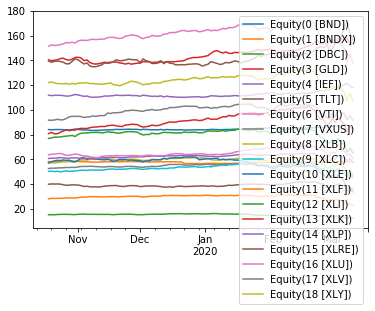

In [6]:
# Verify that bundle has been registered 
from zipline.data import bundles
bundle = bundles.load(bundle_name)
assets = bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)
symbols = [a.symbol for a in assets]

print('Bundle details:', bundles.bundles[bundle_name])
print('\nAsset list:', bundle.asset_finder.retrieve_all(bundle.asset_finder.sids))
print()

# See sample of data
from zipline.data.data_portal import DataPortal
from zipline.utils.calendars import get_calendar
my_data = DataPortal(bundle.asset_finder, get_calendar(args['calendar']),
                       bundle.equity_daily_bar_reader.first_trading_day,
                       equity_minute_reader=bundle.equity_minute_bar_reader,
                       equity_daily_reader=bundle.equity_daily_bar_reader,
                       adjustment_reader=bundle.adjustment_reader)

my_data_pricing = my_data.get_history_window(assets, end_session, 100, '1d', 'close', 'daily')
my_data_pricing.plot()


## Run Algorithms

In [7]:
# initialise variables
import matplotlib.pyplot as plt
from zipline.api import *
from zipline.api import symbols
from zipline.utils.calendars import get_calendar
from zipline import run_algorithm
from datetime import datetime, timedelta
import pytz

tz = pytz.timezone(args['timezone'])
bundle_name = args['bundle'] # bundle = 'alpaca'

raw_start = tz.localize(datetime.strptime(args['start_date'], '%Y-%m-%d'))

# calculate actual start date, 
# taking into account required HISTORY of trading days for given trading calendar
tc = get_calendar(args['calendar'])
# start = tc.sessions_window(start_session, args['history'])[-1] # start = raw_start + trading_days(HISTORY)
start = raw_start

end = tz.localize(datetime.strptime(args['end_date'], '%Y-%m-%d'))
capital_base = args['capital'] # 100000.00 

print(f'Algorithm will start with capital of ${capital_base:,d}.')
print('Backtest from %s to %s' % (start, end))
print('History will be collected for %d trading-days from %s' % (args['history'], raw_start))

Algorithm will start with capital of $1,000,000.
Backtest from 2018-07-21 00:00:00-06:00 to 2020-03-12 00:00:00-06:00
History will be collected for 500 trading-days from 2018-07-21 00:00:00-06:00


### Portfolios based on asset classes

### Algorithm 1 - pre-assembled fixed basket of ETFs with constant-mix rebalancing 

1A - Vanguard Core Series with risk-baskets

In [8]:
from tqdm import tqdm
from algorithms import CRBAlgorithm, run
a_vanguard = CRBAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES")

enabled = False

if (enabled):
    # run algorithm for a range of risk levels
    perfData = []
    step = 5
    for r in tqdm(range(0, 10, step)):
        a_vanguard.risk_level = r
        perfData.append(run("RISK%i" % r, a_vanguard, bundle_name, start, end, capital_base, analyze=False))
                
#         perfData.append(("RISK%i" % r, run_algorithm(start=start, end=end,
#                         initialize=a_vanguard.initialize, handle_data=a_vanguard.handle_data,                            
#                         capital_base=capital_base, environ=os.environ, bundle=bundle_name
#                         # analyze=analyze,
#         )))

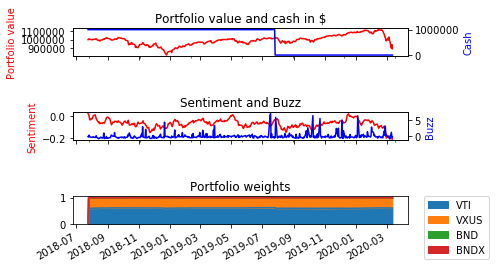

d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
d:\users\edmund\anaconda3\envs\roboadvisor\lib\site-packages\empyrical\stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,


In [9]:
# Compare daily vs monthly rebalancing
a_vanguard.risk_level = 10
a_vanguard.rebalance_freq = 'daily'
test = []
test.append(run("rebal daily", a_vanguard, bundle_name, start, end, capital_base, analyze=True))

a_vanguard.rebalance_freq = 'monthly'
test.append(run("rebal monthly", a_vanguard, bundle_name, start, end, capital_base, analyze=False))

from utils import print_table_from_perf_array
print_table_from_perf_array(test, None)

1B - Ray Dalio's simplified "All Weather" Portfolio that is designed to weather through any financial climate.
It advocates the following distribution:
* 30% stocks (eg VTI)
* 40% long-term bonds (eg TLT)
* 15% intermediate-term bonds (eg IEF)
* 7.5% gold (eg GLD)
* 7.5% commodities (eg DBC)

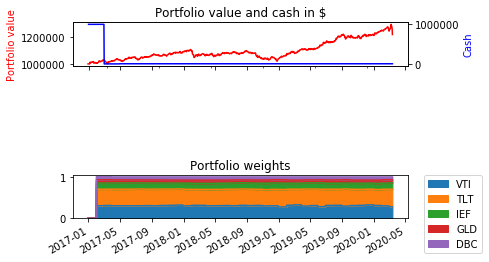

In [11]:
from algorithms import CRBAlgorithm
a_dalio = CRBAlgorithm(verbose=False, grp="DALIO", subgrp="ALL_WEATHER")

if ('perfData' not in locals()): perfData = []
perfData.append(run("All Weather", a_dalio, bundle_name, start, end, capital_base))

### Algorithm 2 - pre-assembled fixed basket of ETFs with Modern Portfolio Theory for rebalancing

MPT (max sharpe)


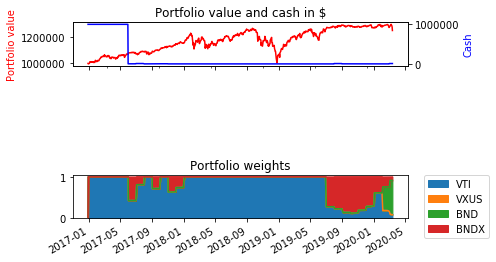

MPT (min volatility)


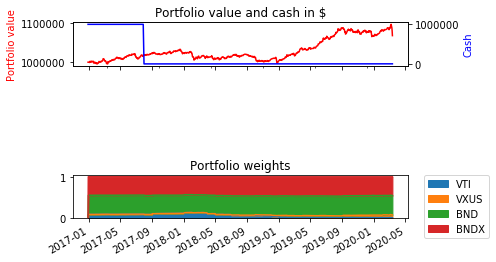

In [12]:
from algorithms import OptAlgorithm

COLLECT_BEFORE_TRADING = False
if ('perfData' not in locals()): perfData = []

# MPT for max-sharpe
a_mpt1 = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='max_sharpe')

# MPT for min-volatility
a_mpt2 = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='min_volatility')


print('MPT (max sharpe)')
perfData.append(run("MPT (max sharpe)", a_mpt1, bundle_name, start, end, capital_base))

print('MPT (min volatility)')
perfData.append(run("MPT (min volatility)", a_mpt2, bundle_name, start, end, capital_base))

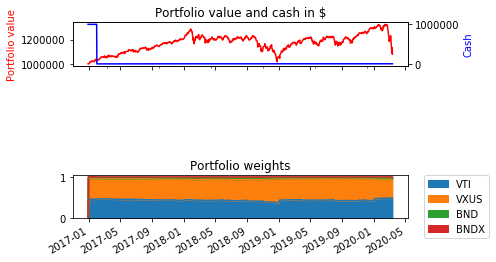

In [13]:
from algorithms import OptAlgorithm

COLLECT_BEFORE_TRADING = False
if ('perfData' not in locals()): perfData = []

# Hierarchical risk parity portfolio
a_hrp = OptAlgorithm(verbose=False, grp="VANGUARD", subgrp="CORE_SERIES", 
                      collect_before_trading=COLLECT_BEFORE_TRADING,
                      history=args['history'], objective='hrp')
perfData.append(run("HRP", a_hrp, bundle_name, start, end, capital_base))

### Results Comparison

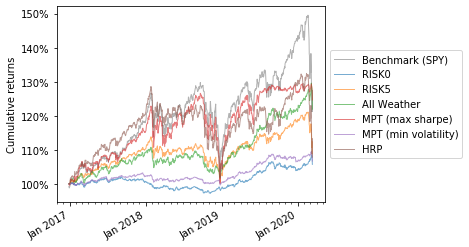

In [23]:
# Get benchmark returns and compare it with our algorithm's returns
from zipline.data.benchmarks import get_benchmark_returns 
from utils import plot_rolling_returns_from_perf_array

bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']
plot_rolling_returns_from_perf_array(perfData, bm_returns)

In [24]:
from utils import print_table_from_perf_array
print_table_from_perf_array(perfData, bm_returns, True)

### Portfolios based on sectors
with universe of 11 SPDR sector ETFs

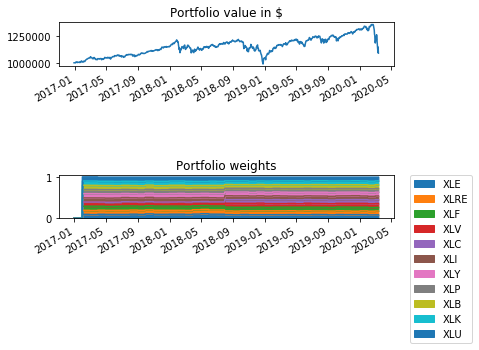

In [25]:
from algorithms import CRBAlgorithm
a_spy1 = CRBAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS")

if ('perfSPDR' not in locals()): perfSPDR = []
perfSPDR.append(run("Constant-Rebalancing (Equal weights)", a_spy1, bundle_name, start, end, capital_base))

MPT (max sharpe)


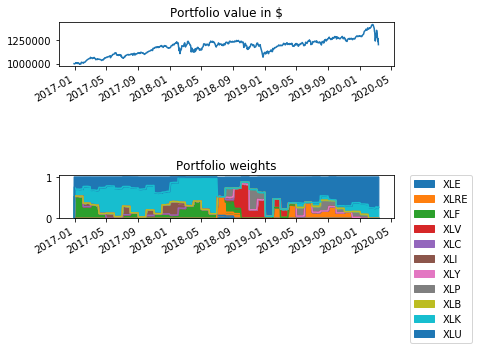

MPT (min volatility)


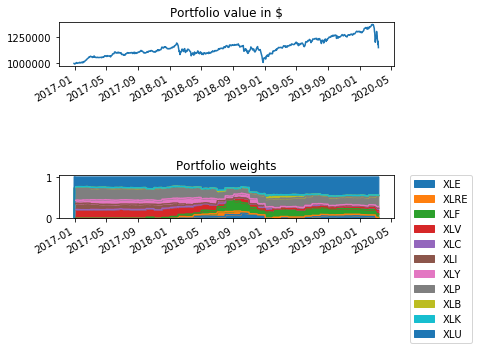

HRP


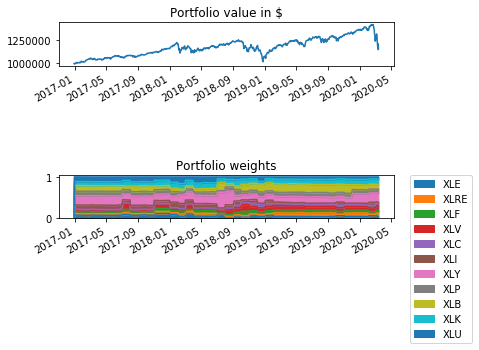

In [26]:
from algorithms import OptAlgorithm
a_spy2_ms = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='max_sharpe')
a_spy2_mv = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='min_volatility')
a_sp2_hrp = OptAlgorithm(verbose=False, grp="SPDR", subgrp="ALL_SECTORS", 
                      collect_before_trading=False,
                      history=args['history'], objective='hrp')

if ('perfSPDR' not in locals()): perfSPDR = []
print("MPT (max sharpe)")
perfSPDR.append(run("MPT (max sharpe)", a_spy2_ms, bundle_name, start, end, capital_base))

print("MPT (min volatility)")
perfSPDR.append(run("MPT (min volatility)", a_spy2_mv, bundle_name, start, end, capital_base))

print("HRP")
perfSPDR.append(run("HRP", a_sp2_hrp, bundle_name, start, end, capital_base))

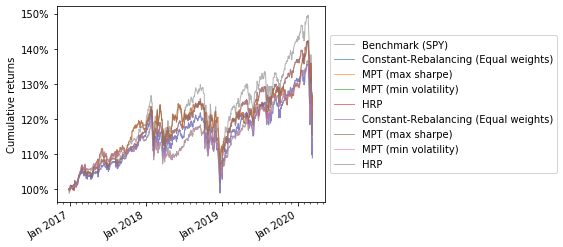

In [27]:
# Get benchmark returns and compare it with our algorithm's returns
from zipline.data.benchmarks import get_benchmark_returns 
from utils import plot_rolling_returns_from_perf_array
from utils import print_table_from_perf_array

bm_returns = get_benchmark_returns(args['benchmark'], start, end)  # requires network connection
bm_returns.name = 'Benchmark (%s)' % args['benchmark']

plot_rolling_returns_from_perf_array(perfSPDR, bm_returns)
print_table_from_perf_array(perfSPDR, bm_returns, True)

### Use a prediction model to optimise portfolio

Buy the index SPY, but use trading signals from the prediction model. 
Baseline: Buy-and-hold SPY

In [ ]:
# TODO

Use All-Weather portfolio, but use trading signals to adjust allocation (eg shift to bonds/gold when market is bad)
Baseline: All-Weather

In [ ]:
# TODO

In [ ]:
Use Modern Portfolio Theory, but use trading signals to adjust upper and lower bounds of 'risk'
Baseline: Modern Portfolio Theory

In [ ]:
# TODO

Use 1-month strongest and most bullist stocks for portfolio selection (https://www.tradefollowers.com/strength/twitter_strongest.jsp?tf=1m)

In [ ]:
# TODO

# Testing area

### Toy-example for Modern Portfolio Theory (MPT) 
Modern portfolio theory applied on randomly-generated returns for a number of assets

Adapted from https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Expected annual return: 737.4%
Annual volatility: 1340.0%
Sharpe Ratio: 0.55
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Expected annual return: 106.6%
Annual volatility: 782.8%
Sharpe Ratio: 0.13


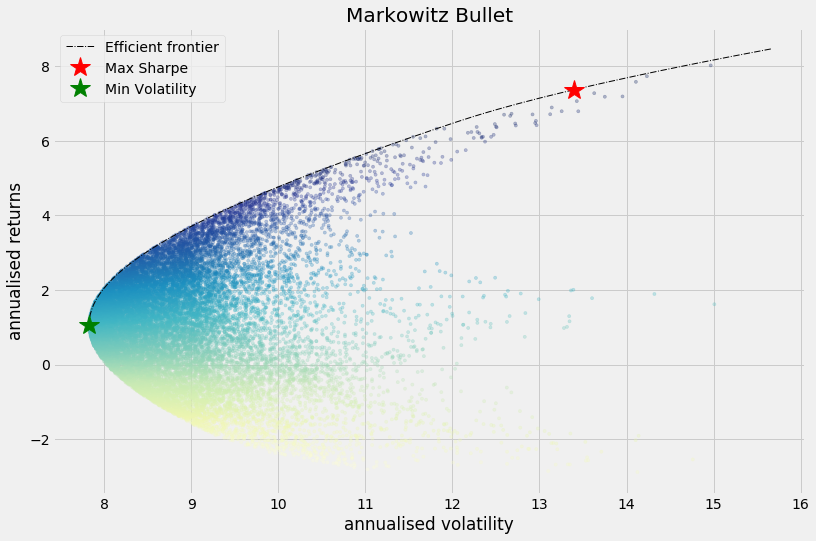

In [1]:
import numpy as np
import pandas as pd
from utils import optimal_portfolio, generate_markowitz_bullet
from pypfopt import expected_returns

n_assets = 4 # number of different stocks
n_obs = 1000 # number of history points to take mean of
return_vec = np.random.randn(n_obs, n_assets) # randomly create returns

prices_ = expected_returns.prices_from_returns(pd.DataFrame(return_vec))
_ = generate_markowitz_bullet(prices_, num_random=20000, plot_individual=False)

### Modern Portfolio Theory (MPT) applied on actual stocks
Using assets selected in Vanguard ETF strategic model portfolios (Core Series), according to
https://advisors.vanguard.com/iwe/pdf/FASINVMP.pdf

In [2]:
import pandas as pd
from yahoofinancials import YahooFinancials  # https://github.com/JECSand/yahoofinancials

end = pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

# Vanguard Core Series
tickers = ['VTI', 'VXUS', 'BND', 'BNDX']

yahoo_financials = YahooFinancials(tickers)
data = yahoo_financials.get_historical_price_data(
    start.strftime('%Y-%m-%d'), 
    end.strftime('%Y-%m-%d'), 
    'daily'
)

In [3]:
import plotly.graph_objects as go
import numpy as np

SIZE = 100
data_title = 'VANGUARD Core Series'

df_data_all = {}
df_data = {} # only last n

for i in range(len(tickers)):
    df_data_all[i] = pd.DataFrame(data[tickers[i]]['prices']).filter(['formatted_date', 'adjclose'])    
    df_data[i] = pd.DataFrame(data[tickers[i]]['prices'])[-(SIZE+1):].filter(['formatted_date', 'adjclose'])
    
# returns_V = np.column_stack((df1, df2, df3, df4))
returns_V = np.column_stack(tuple(df_data[i]['adjclose'] for i in range(len(tickers))))
returns_V = np.diff(returns_V, axis=0) / returns_V[1:,:] * 100
print('Shape of returns:', returns_V.shape)
print(returns_V[0:5])

# Plot historical data
fig = go.Figure()
for i in range(len(tickers)):
    fig.add_trace(go.Scatter(x=df_data_all[i]['formatted_date'], 
                             y=df_data_all[i]['adjclose'], 
                             name=tickers[i], 
#                              line_color='deepskyblue', 
                             opacity=0.8))
    
# Use date string to set xaxis range
fig.update_layout(xaxis_range=[start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')],
                   title_text="Components in %s" % data_title)
fig.show()

Shape of returns: (100, 4)
[[ 0.80513939  0.76801885  0.33018693  0.37351252]
 [ 1.28898318  0.66510167  0.16482135  0.01697617]
 [-0.39560439 -0.33365283 -0.25967887 -0.25527925]
 [-1.64247272 -0.85114793  0.04719701  0.10200621]
 [ 0.91167486  0.78553832 -0.1181137  -0.01699172]]


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Expected annual return: 10.3%
Annual volatility: 3.5%
Sharpe Ratio: 2.38
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Expected annual return: 6.3%
Annual volatility: 2.8%
Sharpe Ratio: 1.54


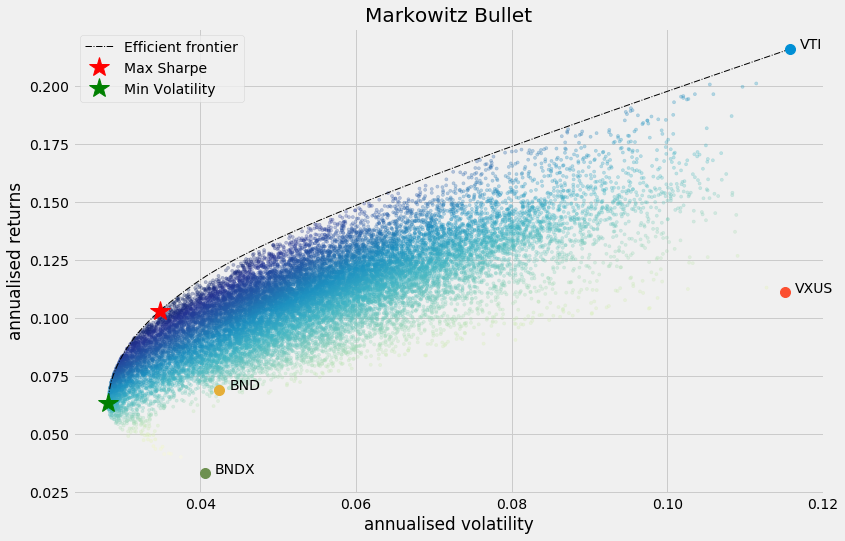

In [4]:
# Markowitz bullet representation inspired from 
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

import pandas as pd
import numpy as np
from utils import generate_markowitz_bullet, get_mu_sigma

prices = pd.DataFrame(np.column_stack(tuple(df_data[i]['adjclose'] for i in range(len(tickers)))), columns=tickers)
_ = generate_markowitz_bullet(prices)

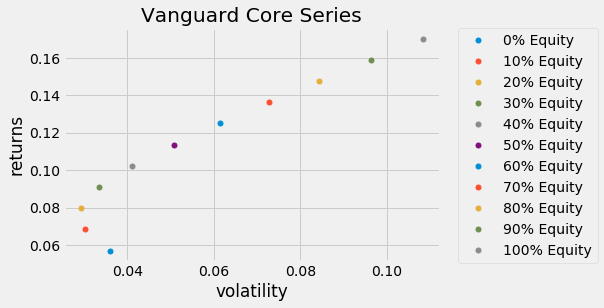

In [5]:
from pypfopt.base_optimizer import portfolio_performance
import matplotlib.pyplot as plt
from utils import get_mu_sigma


# VTI, VXUS, BND, BNDX
core_series_allocation = {
    0: (0, 0, 0.686, 0.294),
    1: (0.059, 0.039, 0.617, 0.265),
    2: (0.118, 0.078, 0.549, 0.235),
    3: (0.176, 0.118, 0.480, 0.206),
    4: (0.235, 0.157, 0.412, 0.176),
    5: (0.294, 0.196, 0.343, 0.147),
    6: (0.353, 0.235, 0.274, 0.118),
    7: (0.412, 0.274, 0.206, 0.088),
    8: (0.470, 0.314, 0.137, 0.059),
    9: (0.529, 0.353, 0.069, 0.029),
    10: (0.588, 0.392, 0, 0)
}

# Get mu and S from prices
mu, S = get_mu_sigma(prices)

# Plot different risk-level portfolios from Vanguard Core Series on same graph
for k,allocation in core_series_allocation.items():
    returns, volatility, _ = portfolio_performance(mu, S, allocation)
    plt.plot(volatility, returns, 'o', markersize=5, label='%i%% Equity' % (k*10))
    
plt.xlabel('volatility')
plt.ylabel('returns')
plt.title('Vanguard Core Series')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
print()
